# Peliculas data bases

In [0]:
import os            #  trabajar sobre el sistema operativo
import sys           #  manipular archivos (cortar, copiar, borrar, crear)
import tarfile       #  Manipular archivos comprimidos (comprimir, descomprimir)
import time          #  calcular tiempo (en este caso tiempo de descarga de archivo)


source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'

In [0]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size
    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d segundos transcurrido" %
                    (percent, progress_size / (1024.**2), speed, duration))
    sys.stdout.flush()


if not os.path.isdir('aclImdb') and not os.path.isfile('aclImdb_v1.tar.gz'):
    
    if (sys.version_info < (3, 0)):
        import urllib
        urllib.urlretrieve(source, target, reporthook)
    
    else:
        import urllib.request
        urllib.request.urlretrieve(source, target, reporthook)


100% | 80 MB | 6.37 MB/s | 12 segundos transcurrido

Extraemos todos los archivos de la base de datos


In [0]:
if not os.path.isdir('aclImdb'):

    with tarfile.open(target, 'r:gz') as tar:
        tar.extractall()


In [0]:
pip install pyprind  # instalar librería para visualizar el progreso de ejecución una tarea en background

In [0]:
import pyprind
import pandas as pd
import os

basepath = 'aclImdb'

In [0]:
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)

df = pd.DataFrame()

for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], 
                           ignore_index=True)
            pbar.update()

df.columns = ['review', 'sentiment']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:30


In [0]:
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

df.to_csv('movie_data.csv', index=False, encoding='utf-8')

import pandas as pd

df = pd.read_csv('movie_data.csv', encoding='utf-8')
df.head(3)


,review,sentiment
0,Finally got to see this classic TV movie on an...,1
1,I'm sorry to say this but I didn't enjoy this ...,0
2,Liked Stanley & Iris very much. Acting was ver...,1


# Vectorizando Texto

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

new_text = ['probando un texto para pruebas de texto']
vector= CountVectorizer(stop_words=None)
vector.fit(new_text)

print(vector.vocabulary_)

{'probando': 2, 'un': 5, 'texto': 4, 'para': 1, 'pruebas': 3, 'de': 0}


In [0]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

print(count.vocabulary_)
print()
print(bag.toarray())


{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, 
                         norm='l2', 
                         smooth_idf=True)
np.set_printoptions(precision=2)

print(tfidf.fit_transform(count.fit_transform(docs)).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


# Conexion a google drive para cargar csv


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
df = pd.DataFrame()
df = pd.read_csv('/content/gdrive/My Drive/movie_reviews/movie_data.csv', encoding='utf-8')

In [0]:
df.head(3)

,review,sentiment
0,Finally got to see this classic TV movie on an...,1
1,I'm sorry to say this but I didn't enjoy this ...,0
2,Liked Stanley & Iris very much. Acting was ver...,1


# Funcion para limpiar textos de emoticones

In [0]:
import re

# creamos una funcion llamada preprocessor
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = (re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', ''))
    return text

In [0]:
print(df.loc[0, 'review'][-50:])
print("---mismo texto limpiado---")
preprocessor(df.loc[0, 'review'][-50:])


**Sistema de limpieza**

In [0]:
df['review'] = df['review'].apply(preprocessor)

In [0]:
print(df.loc[0, 'review'])


finally got to see this classic tv movie on an unofficial disc recorded from an old vhs it is a classic piece of horror its a pity more of this neglected corner of horror in terms of official releases on dvd and vhs the tv horror movie recommended for all fans of the 70 s tv movie much like trilogy of terror those interested should get the book on the subject by david deal television fright films of the 70 s email me for a chance to see it its fabulous to see it again it does have it problems like many tv movies they have to be rather inventive in the effects dept and even at 70 mins it can seem to drag possibly we are all used to more modern editing but still great stuff and far better than many theatrical frights released today 


**Tokenizado**

In [0]:
def tokenizer(text):
    return text.split()
tokenizer('runners like running and thus they run')


['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [0]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tokenizer_porter('runners like running and thus they run')

*Instalar paquete nltk*

In [0]:
pip install nltk

In [0]:
import nltk
#nltk.download(“all")
#nltk.download("popular")
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

[w for w in tokenizer_porter('a runner likes running and runs a lot is very important')
if w not in stop]


['runner', 'like', 'run', 'run', 'lot', 'veri', 'import']

# Regresion logistica

In [0]:
from sklearn.pipeline import Pipeline                         # permite implementar métodos de ajuste y transformación
from sklearn.linear_model import LogisticRegression           # modelo de regresión logistica
from sklearn.feature_extraction.text import TfidfVectorizer   #conversor de texto a vector
from sklearn.model_selection import GridSearchCV              #búsqueda de cuadrícula con validación cruzada (para usar con regresión logistica)

In [0]:
# separamos los datos de entrenamiento y de pruebas
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [0]:
#propiedades de la conversor de texto a vectores
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

def tokenizer(text):
    return text.split()

In [0]:
#creación de dos diccionarios (1° para cálculos de TF-IDF, 2° para entrenar modelo con regresión logistica
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}, ]

Regresion logistica

In [0]:
#mezclamos regresión lineal y vectores de textos en un solo proceso
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

In [0]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

**Comienza a entrenar**

In [0]:
gs_lr_tfidf.fit(X_train, y_train)

In [0]:
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]},
              ]

In [0]:
print('Mejores set de parametros: %s ' % gs_lr_tfidf.best_params_)
print('CV exactitud: %.3f' % gs_lr_tfidf.best_score_)


In [0]:
clf = gs_lr_tfidf.best_estimator_
print('Test exactitud: %.3f' % clf.score(X_test, y_test))


# Download Twitter DataBase


In [0]:
import os
import tweepy as tw
import pandas as pd

In [0]:
consumer_key= 'ZEAZ01NKdPCQUFavglQUDPSMG'
consumer_secret= '5NrAQih6u0EKuLZ52i0obUhxUmv8TyXtIcF4dIKqf6oZIXyn8f'
access_token= '2160576646-JC5oXj9YgWTunp99rJlwUAeRcvVK3C92bgi2jt6'
access_token_secret= 'D3ffvHn6xqe6bMFhRUoaMwIzgjLkIcDuoAb5y3n5VAQCx'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [0]:
# Postear un  tweet desde Python

api.update_status("#USTATUNJA, subiendo mi primer prueba tweet desde PYTHON")


Status(_api=<tweepy.api.API object at 0x7ff49eaf8fd0>, _json={'created_at': 'Fri Mar 27 20:01:24 +0000 2020', 'id': 1243629214214934530, 'id_str': '1243629214214934530', 'text': '#USTATUNJA, subiendo mi primer prueba tweet desde PYTHON', 'truncated': False, 'entities': {'hashtags': [{'text': 'USTATUNJA', 'indices': [0, 10]}], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '<a href="https://www.ustatunja.edu.co/" rel="nofollow">usta_deep_learning_jdgg</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 2160576646, 'id_str': '2160576646', 'name': 'Juan Diego Gomez G.', 'screen_name': 'Gojdioan', 'location': '', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 8, 'friends_count': 41, 'listed_count': 0, 'created_at': 'Wed Oct 30 17:19:42 +0000 2013', 'favourites_count': 41, 'utc_offset'

**Busqueda**

In [0]:
# Definir el termino de la busqueda y la fecha de inicio
search_words = '#COVID19'
date_since = '2020-01-01'

#Para que no tome los retweets
new_search = search_words + " -filter:retweets"
new_search


'#COVID19 -filter:retweets'

**traer coleccion**

In [0]:
# Collecional tweets
tweets = tw.Cursor(api.search,
              q=new_search,
              lang="en",
              since=date_since).items(1000)
tweets


**Visualizar tweets**

In [0]:
#Vizualizar Tweets

[tweet.text for tweet in tweets]

In [0]:
#Definimos columnas para ver info del tweet.

data_frame = [[tweet.user.screen_name, tweet.user.location,tweet.text] for tweet in tweets]

tw_dataframe = pd.DataFrame(data= data_frame , columns=["user","location","text"])
tw_dataframe

#Si lo queremo vizualizar o almacenar en CSV
tw_dataframe.to_csv('twitter_COVID19_data.csv', index=False, encoding='utf-8')

#***Corpus*** 

In [0]:
#Librerias necesarias
import xml.etree.ElementTree as etree
import csv
from os import scandir
from sklearn.model_selection import train_test_split

**Convertir XML a CSV**

In [0]:
def list_to_csv(data, filename):
  with open(filename, 'w', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator='\n', quoting=csv.QUOTE_NONNUMERIC)
    writer.writerows(data)

In [0]:
#Cargar de un CSV a una LISTA (messages | labels)
def csv_to_lists(filename):
  messages = []
  labels = []
  with open(filename, 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      messages.append(row[1])
      labels.append(row[2])
  return messages, labels

***Funciones para prasear xml en un lista según cada corpus***

In [0]:
#Corpus de general   | tweetid | content | sentiments/polarity/value
def general_tass_to_list(filename):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = tweet.find('sentiments/polarity/value').text
    data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

In [0]:
#Corpus politics | tweetid | content | sentiments/polarity
def politics_tass_to_list(filename):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    aux = next((e for e in tweet.findall('sentiments/polarity') if e.find('entity') == None), None)
    if aux != None:
      polarityValue = aux.find('value').text
      data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

In [0]:
#Corpus internacional | tweetid | content | sentiments/polarity
def intertass_tass_to_list(filename, qrel=None):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = tweet.find('sentiment/polarity/value').text
    if polarityValue == None:
      polarityValue = qrel[tweetId]
      data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

***Funcion para listar el corpus general***

In [0]:
#Listar los id tweets | sentiment :P (Positivo) - N (Negativo) - NEU (NEUtro) - NONE (sin sentimiento)
def gold_standard_to_dict(filename):
  with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    data = {rows[0]: rows[1] for rows in reader}

  return data

# ***Función para separar el 100% del corpus entre: Train : 70% - Test: 30%***

In [0]:
def generate_train_test_subsets(data, size):
  codes = [d[0] for d in data]
  labels = [d[2] for d in data]
  codes_train, codes_test, labels_train, labels_test = train_test_split(codes, labels, train_size=size)
  train_data = [d for d in data if d[0] in codes_train]
  test_data = [d for d in data if d[0] in codes_test]
  return train_data, test_data

In [0]:
#tomamos el corpus internacional (test) y generamos una lista del ID del tweet y el sentimiento para agregarlo a la data
qrel = gold_standard_to_dict("/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/tass/intertass-sentiment.qrel")
data = []
data.extend(general_tass_to_list("/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/tass/general-test-tagged-3l.xml"))
data.extend(general_tass_to_list("/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/tass/general-train-tagged-3l.xml"))
data.extend(intertass_tass_to_list("/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/tass/intertass-development-tagged.xml"))
#como el test del corpus internacional esta sin los sentimientos es necesario agregarlos : qrel
data.extend(intertass_tass_to_list("/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/tass/intertass-test.xml", qrel))
data.extend(intertass_tass_to_list("/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/tass/intertass-train-tagged.xml"))
data.extend(politics_tass_to_list("/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/tass/politics-test-tagged.xml"))

train, test = generate_train_test_subsets(data, size=0.7)

list_to_csv(data, '/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/global_dataset.csv')
list_to_csv(train, '/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/train_dataset_30.csv')
list_to_csv(test, '/content/gdrive/My Drive/Analisis_sentimientos_Twitter/datasets/test_dataset_30.csv')

# ***Preprocesamiento***

*Cargar librerías necesarias y variable necesarias*

In [0]:
import re                             #librería para la búsqueda y manipulación de cadenas
from nltk import TweetTokenizer       #librería para tokenizar(separar y clasificar palabras)
from nltk.stem import SnowballStemmer #algoritmo para clasificación de palabras

#variables para mejorar la escritura (opcional)
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'
#definir que el algoritmo de clasificación use el idioma español
_stemmer = SnowballStemmer('spanish')

#definir una variable para la funcion de tokenizar (opcional)
_tokenizer = TweetTokenizer().tokenize

#variable para definir si quiero normalizar: normalize o eliminar: remove los hashtags, menciones y urls en los tweets
_twitter_features="normalize"

#variable para definir si se desea tener convertir o no a la raiz de la palabra.
_stemming=True

In [0]:
#lista de conversión para quitar las tildes a las vocales.
DIACRITICAL_VOWELS = [('á','a'), ('é','e'), ('í','i'), ('ó','o'), ('ú','u'), ('ü','u')]

#lista para corregir algunas palabras coloquiales / jerga en español (obviamente faltan más)
SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
         ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
         ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas')]



***creancion de funciones que serán necesarias para el preprocesamiento de los mensajes***



1.   Método para normalización de risas
2.   Método para eliminar o normalizar menciones, hashtags y URLS
3.   Método global 




In [0]:
# 1. Método para normalizar las risas
def normalize_laughs(message):
  message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
  return message

#Imprimir con el normalizador de risas

print (normalize_laughs("esto muy feliz jajajajaja o no tan feliz jejejejeje o mejor me rio a como papa noel JOJOJO o como en mileniams LOL"))


esto muy feliz twlaugh o no tan feliz twlaugh o mejor me rio a como papa noel twlaugh o como en mileniams twlaugh


In [0]:
# 2. Método para eliminar o normalizar menciones, hashtags y URLS

def process_twitter_features(message, twitter_features):

  message = re.sub(r'[\.\,]http','. http', message, flags=re.IGNORECASE)
  message = re.sub(r'[\.\,]#', '. #', message)
  message = re.sub(r'[\.\,]@', '. @', message)

  if twitter_features == REMOVE:
    # eliminar menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
    message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
  elif twitter_features == NORMALIZE:
    # cuando sea necesario se normalizaran las menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
    message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
    message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)

  return message

#Imprimir con el normalizador de risas
                                               #(MENSAJE, Funcion("normalize","remove"))
print(process_twitter_features("#Rosell, una noche. Adivina quien!! http://t.co/PPAwijRX","normalize"))


twhashtag una noche. Adivina quien!! twurl


In [0]:
# 3.  Método global 

def preprocess(message):
  # convertir a minusculas
  message = message.lower()
        
  # eliminar números, retorno de linea y el tan odios retweet (de los viejos estilos de twitter)
  message = re.sub(r'(\d+|\n|\brt\b)', '', message)
        
  # elimar vocales con signos diacríticos (posible ambigüedad)
  for s,t in DIACRITICAL_VOWELS:
    message = re.sub(r'{0}'.format(s), t, message)
        
  # eliminar caracteres repetidos 
  message = re.sub(r'(.)\1{2,}', r'\1\1', message)
       
  # normalizar las risas
  message = normalize_laughs(message)
        
  # traducir la jerga y terminos coloquiales sobre todo en el español
  for s,t in SLANG:
    message = re.sub(r'\b{0}\b'.format(s), t, message)

  #normalizar/eliminar hashtags, menciones y URL
  message = process_twitter_features(message, _twitter_features)

  #Convertir las palabras a su raiz ( Bonita, bonito) -> bonit 
  if _stemming:
    message = ' '.join(_stemmer.stem(w) for w in _tokenizer(message))

  return message


#Imprimir metodo global

print(preprocess("LOL!! muy graciosa esta paguina https://actualidadpanamericana.com :-) jajajaja muy buena"))

twlaugh ! ! muy gracios esta paguin twurl :-) twlaugh muy buen


# Haciendo Corpus y Analizandolo 

### Twitter descargando dataset


In [0]:
import os
import tweepy as tw
import pandas as pd

consumer_key= 'ZEAZ01NKdPCQUFavglQUDPSMG'
consumer_secret= '5NrAQih6u0EKuLZ52i0obUhxUmv8TyXtIcF4dIKqf6oZIXyn8f'
access_token= '2160576646-JC5oXj9YgWTunp99rJlwUAeRcvVK3C92bgi2jt6'
access_token_secret= 'D3ffvHn6xqe6bMFhRUoaMwIzgjLkIcDuoAb5y3n5VAQCx'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [79]:
# Definir el termino de la busqueda, la fecha de inicio, idioma y cantidad de tweets
search_words = '#Covid19'
date_since = '2020-04-01'
items=1001
language = 'es'

# Para que no tome los retweets
new_search = search_words + " -filter:retweets"
new_search

'#Covid19 -filter:retweets'

In [0]:
# Collecional tweets

cTweets = tw.Cursor(api.search,
              q=new_search,
              lang=language,
              since=date_since).items(items)

In [0]:
#Agrupando en data frames
tweets = [[tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in cTweets]
#tweets = [[tweet.text] for tweet in cTweets]

In [0]:
#Visulizar dataframes sin perder datos
#tweets[:10]

In [82]:
#Definimos columnas para ver info del tweet con lo anterior.
tw_dataframe = pd.DataFrame(data= tweets,columns=["user","location","text"])
#tw_dataframe = pd.DataFrame(data= tweets,columns=["text"])
tw_dataframe[:10]

,user,location,text
0,avides_vgt,Ciudad de Guatemala,"Con un click, en #AgexportHoy encontrará pro..."
1,cubacooperaveNE,Nueva Esparta,Brigada Médica Cubana en Nueva Esparta: Pesqui...
2,soymferreira,"Madrid, Comunidad de Madrid",#15abril Otro de los grandes desafios de ver c...
3,jjocampo_,Colombia,#MePreguntanQue el decreto de la emergencia ec...
4,CyRiveraB,Ilo - Perú.,#Covid19 #Moquegua\nAnuncia el @goremoquegua y...
5,OxfamenPeru,"Lima, Perú","En #AméricaLatina, 54% de mujeres tienen ingre..."
6,ElUniversal,Venezuela,#EUVzla| Si debes a salir a la calle porque ti...
7,justiammyself,,#aprobadogeneral En serio acabo de hablar con ...
8,cdiazp93,"Lima, Peru",Si médicos y enfermeras están luchando x tener...
9,Ayto_Tulum,,"En esta etapa de aislamiento por #COVID19, hay..."


In [0]:
#Si lo queremo vizualizar o almacenar en CSV

file_name= "DATASET_COVID.csv"

tw_dataframe.to_csv(file_name, index=False, encoding='utf-8')
#tw_dataframe = pd.read_csv(file_name, encoding='utf-8')
#tw_dataframe.head(10)

In [84]:
#Visualizar el datafreme y lo almacenamos en df

df = tw_dataframe
df.head(10)

,user,location,text
0,avides_vgt,Ciudad de Guatemala,"Con un click, en #AgexportHoy encontrará pro..."
1,cubacooperaveNE,Nueva Esparta,Brigada Médica Cubana en Nueva Esparta: Pesqui...
2,soymferreira,"Madrid, Comunidad de Madrid",#15abril Otro de los grandes desafios de ver c...
3,jjocampo_,Colombia,#MePreguntanQue el decreto de la emergencia ec...
4,CyRiveraB,Ilo - Perú.,#Covid19 #Moquegua\nAnuncia el @goremoquegua y...
5,OxfamenPeru,"Lima, Perú","En #AméricaLatina, 54% de mujeres tienen ingre..."
6,ElUniversal,Venezuela,#EUVzla| Si debes a salir a la calle porque ti...
7,justiammyself,,#aprobadogeneral En serio acabo de hablar con ...
8,cdiazp93,"Lima, Peru",Si médicos y enfermeras están luchando x tener...
9,Ayto_Tulum,,"En esta etapa de aislamiento por #COVID19, hay..."


### Prospocesamiento


In [0]:
# PREPROCESAMIENTO

import re                             #librería para la búsqueda y manipulación de cadenas
from nltk import TweetTokenizer       #librería para tokenizar(separar y clasificar palabras)
from nltk.stem import SnowballStemmer #algoritmo para clasificación de palabras

#variables para mejorar la escritura (opcional)
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'
#definir que el algoritmo de clasificación use el idioma español
_stemmer = SnowballStemmer('spanish')

#definir una variable para la funcion de tokenizar (opcional)
_tokenizer = TweetTokenizer().tokenize

#variable para definir si quiero normalizar: normalize o eliminar: remove los hashtags, menciones y urls en los tweets
_twitter_features="normalize"

#variable para definir si se desea tener convertir o no a la raiz de la palabra.
_stemming=False

In [0]:
#lista de conversión para quitar las tildes a las vocales.
DIACRITICAL_VOWELS = [('á','a'), ('é','e'), ('í','i'), ('ó','o'), ('ú','u'), ('ü','u')]

#lista para corregir algunas palabras coloquiales / jerga en español (obviamente faltan más)
SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
         ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
         ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas')]

***creancion de funciones que serán necesarias para el preprocesamiento de los mensajes***



1.   Método para normalización de risas
2.   Método para eliminar o normalizar menciones, hashtags y URLS
3.   Metodo para limpiar Emotes
4.   Método global 


In [0]:
# 1. Método para normalizar las risas
def normalize_laughs(message):
  message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
  return message

#Imprimir con el normalizador de risas

##df['text'] = df['text'].apply(normalize_laughs)
##print(df.loc[1])

In [0]:
# 2. Método para eliminar o normalizar menciones, hashtags y URLS

def process_twitter_features(message, twitter_features):

  message = re.sub(r'[\.\,]http','. http', message, flags=re.IGNORECASE)
  message = re.sub(r'[\.\,]#', '. #', message)
  message = re.sub(r'[\.\,]@', '. @', message)

  if twitter_features == REMOVE:
    # eliminar menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
    message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
  elif twitter_features == NORMALIZE:
    # cuando sea necesario se normalizaran las menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
    message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
    message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)

  return message

def process_twitter_featuresMej(message):
  #normalizar/eliminar hashtags, menciones y URL
  message = process_twitter_features(message, _twitter_features)
  return message

#Imprimir con el eliminar o normalizar menciones, hashtags y URLS

                           #(MENSAJE, Funcion("normalize","remove"))
##print(process_twitter_features(df['text'].loc[1] ,"normalize"))

#Imprimir con el normalizar menciones, hashtags y URLS

##df['text'] = df['text'].apply(process_twitter_featuresMej)
##print(df.loc[1])

In [0]:
#3 Limpiar emoticones

def limp_emptes(menssage):
    menssage = re.sub('<[^>]*>', '', menssage)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',menssage)
    menssage = (re.sub('[\W]+', ' ', menssage.lower()) +' '.join(emoticons).replace('-', ''))
    return menssage

#Imprimir con limpiar emoticones

##print(limp_emptes(df['text'].loc[1]))
##print(df.loc[1])

In [90]:
# 4.  Método global 

def preprocess(message):
  # convertir a minusculas
  message = message.lower()
        
  # eliminar números, retorno de linea y el tan odios retweet (de los viejos estilos de twitter)
  message = re.sub(r'(\d+|\n|\brt\b)', '', message)
        
  # elimar vocales con signos diacríticos (posible ambigüedad)
  for s,t in DIACRITICAL_VOWELS:
    message = re.sub(r'{0}'.format(s), t, message)
        
  # eliminar caracteres repetidos 
  message = re.sub(r'(.)\1{2,}', r'\1\1', message)
       
  # normalizar las risas
  message = normalize_laughs(message)
        
  # traducir la jerga y terminos coloquiales sobre todo en el español
  for s,t in SLANG:
    message = re.sub(r'\b{0}\b'.format(s), t, message)

  #normalizar/eliminar hashtags, menciones y URL
  message = process_twitter_features(message, _twitter_features)

  #Convertir las palabras a su raiz ( Bonita, bonito) -> bonit 
  if _stemming:
    message = ' '.join(_stemmer.stem(w) for w in _tokenizer(message))

  # Limpiar emoticones
  # message = limp_emptes(message)

  return message


#Imprimir metodo global

print(preprocess(df['text'].loc[1]))
print("\n")
print(df.loc[1])

brigada medica cubana en nueva esparta: pesquisando la comunidad para prevenir la pandemia identificado nuevos caso… twurl


user                                          cubacooperaveNE
location                                        Nueva Esparta
text        Brigada Médica Cubana en Nueva Esparta: Pesqui...
Name: 1, dtype: object


In [91]:
# Almacenar CSV limpio

df['text'] = df['text'].apply(preprocess)
print(df.loc[1])

file_name= "DATASET_CLEAN_COVID.csv"
df.to_csv(file_name, index=False, encoding='utf-8')

user                                          cubacooperaveNE
location                                        Nueva Esparta
text        brigada medica cubana en nueva esparta: pesqui...
Name: 1, dtype: object


## Descargamos la libreria de stopwords


In [92]:
#Descargamos la libreria de stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Accedemos a Google Drive

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/Analisis_sentimientos_Twitter/twitterclassifier')

## Aplicamos preprocesamiento al CSV y creamos un nuevo CSV limpio

In [0]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

In [0]:
import pickle
import re
import os
from vectorizer import vect
from nltk.corpus import stopwords
stop = stopwords.words('spanish')
clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

In [0]:
import pickle
import os
#creo una carpeta en mi google drive para guardar los archivos serializados
dest = os.path.join('/content/drive/My Drive/Analisis_sentimientos_Twitter/twitterclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
#convertimos el clasificador y el stopword en archivo/objectos pkl
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)
#Es importante recordar que deben verificar que los dos archivos esten en su drive

In [98]:
pip install pyprind

In [0]:
import numpy as np
import pandas as pd
import pyprind

#Hay que tener los CSV en drive en la carpeta
df = pd.read_csv("DATASET_CLEAN_COVID.csv", encoding='utf-8')
#creamos una columna llamada Sentimient donde guardaremos la predicción
df['sentiment'] = ''
#creamos una columna llamada Probability donde guardaremos la acertabilidad que dio el clasificador
df['probability']= 0
#conversión de sentimientos (numeros a palabras)= NONE->-1 | NEU -> 0 | P->1 | N->2
label = {-1:'Sin sentimiento', 0:'Neutro', 1:'Positivo',2: 'Negativo'}
for rowid in range(len(df.index)):
  text=df['text'][rowid]
  textConvert = vect.transform([text]) 
  df['sentiment'][rowid]=label[clf.predict(textConvert)[0]]
  df['probability'][rowid]=np.max(clf.predict_proba(textConvert))*100
  #pbar.update()
#df.head(20)
df.to_csv('DATASET_TWEETS_COVID_analysis.csv', index=False, encoding='utf-8')

### Graficar nuevo archivo

sentiment
Negativo     14
Positivo    987
dtype: int64


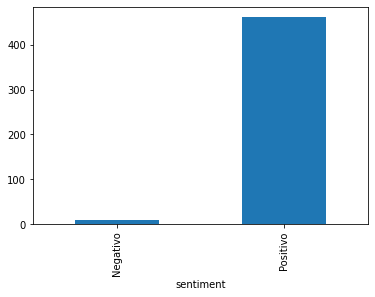

In [101]:
import matplotlib.pyplot as plt
#sentimientos = df["sentiment"].unique()
df.groupby('sentiment')['location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
#df.groupby(['sentiment']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

sentiment
Negativo     14
Positivo    987
dtype: int64


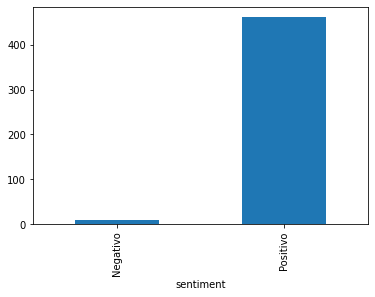

In [102]:
import matplotlib.pyplot as plt
#sentimientos = df["sentiment"].unique()
df.groupby('sentiment')['location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
#df.groupby(['sentiment']).size().unstack().plot(kind='bar',stacked=True)
plt.show()